In [1]:
import DGM
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Solution parameters (domain on which to solve PDE)
t_low = 0.0   # time lower bound
X_low = 0.0  # Rod lower bound
X_high = 1.0          # Rod upper bound

# terminal time 
T = 1.0

# neural network parameters
num_layers = 5
nodes_per_layer = 10
learning_rate = 0.0001

# Training parameters
sampling_stages  = 100 # number of times to resample new time-space domain points
steps_per_sample = 1000    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 1000
nSim_Boundary = 100
nSim_initial = 1000

# multipliers for oversampling i.e. draw X from [X_low - X_oversample, X_high + X_oversample]
X_oversample = 0.0
t_oversample = 0.0



# Save options
saveOutput = False
saveName   = 'HeatInRodProblem'
saveFigure = False
figureName = 'HeatInRodProblem'



def sampler(nSim_interior, nSim_Boundary, nSim_initial):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_initial: number of space points at initial time to sample (initial condition)
    ''' 
    
    # Sampler #1: domain interior    
    # over sampleing
    # t_interior = np.random.uniform(low=t_low - 0.5*(T-t_low), high=T, size=[nSim_interior, 1])
    # X_interior = np.random.uniform(low=X_low - 0.5*(X_high-X_low), high=X_high + 0.5*(X_high-X_low), size=[nSim_interior, 1])
    
    # No over sampling
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    X_interior = np.random.uniform(low=X_low , high=X_high, size=[nSim_interior, 1])


    # Sampler #2: spatial boundary
    # We only have 2 Boundary Conditions (each end of the rod ie they are both spatial)
    # TODO this brings up the intesting question should we scale this loss 
    # ... we just include all the boundary condtions
    t_boundary = np.random.uniform(low=0, high=T,  size=[nSim_Boundary, 1])
    # X_boundary should be 0 or 1 so we just random sample between 0 and 1 and use the mask >0.5 to create an even distribution
    X_boundary = (np.random.uniform(low=0, high=1,  size=[nSim_Boundary, 1])>0.5).astype(np.float32)
    
    
    # Sampler #3: initial/terminal condition
    t_initial = np.zeros((nSim_initial, 1))
    #X_initial = np.random.uniform(low=0.01 , high=0.99 , size = [nSim_initial, 1])
    X_initial  = np.random.normal(loc=0.5 , scale=0.05 , size = [nSim_initial-50, 1])
    X_initial = np.concatenate((X_initial, np.random.uniform(low=0.01 , high=0.99 , size = [50, 1])))
    
    
    return t_interior, X_interior, t_boundary, X_boundary, t_initial, X_initial

def loss(model, t_interior, X_interior, t_boundary, X_boundary, t_initial, X_initial):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        X_interior: sampled space points in the interior of the function's domain
        t_initial: sampled time points at terminal point (vector of terminal times)
        X_terminal: sampled space points at terminal time
    ''' 
    
    # Loss term #1: PDE
    # compute function value and derivatives at current sampled point
    V = model(t_interior, X_interior)
    V_t = tf.gradients(V, t_interior)[0]
    V_x = tf.gradients(V, X_interior)[0]
    V_xx = tf.gradients(V_x, X_interior)[0]
    # We have that the PDE for heat in a rod is v_t = v_xx -> v_t - v_xx = 0
    diff_V =  V_t - V_xx

    # compute average L2-norm of differential operator
    L1 =   tf.reduce_mean(tf.square(diff_V)) # tf.constant(0, tf.float32)#
    
    # Loss term #2: boundary condition
    # We are assuming that the ends of the rod fixed at temp 0.
    diff_ends = model(t_boundary, X_boundary) - 0 
    # TODO we may also need to enforce that the boundary does not change (ie V_t at x=0 and x=1 is always 0 )
    
    L2 = tf.reduce_mean(tf.square(diff_ends)) # tf.constant(0, tf.float32) #
    
    # Loss term #3: initial/terminal condition
    # Assuming a triangle start function
    ic_cond = tf.greater(X_initial, 1/2)
    target_initial = tf.where(ic_cond, tf.add(2.0, tf.multiply(-2.0,X_initial)), tf.multiply(2.0,X_initial))
    
    
    #target_initial = X_initial
    # tf.where(ic_cond, tf.multiply(2.0,X_initial), tf.add(2.0, tf.multiply(-2.0,X_initial)))
    
    # https://stackoverflow.com/questions/37980543/writing-piece-wise-functions-in-tensorflow-if-then-in-tensorflow/44981465
    # ^ TypeError: Using a tf.Tensor as a Python bool is not allowed. Use if t is not None: instead of if t: to test if a tensor is defined, and use the logical TensorFlow ops to test the value of a tensor.
    #np.piecewise(X_initial, [X_initial < 1/2, X_initial>=1/2], [lambda x:2*x,lambda x:2-2*x])
    fitted_initial = model(t_initial, X_initial)
    
    L3 = tf.reduce_mean( tf.square(fitted_initial - target_initial) )

    return L1, L2, L3



#%% Set up network

# initialize DGM model (last input: space dimension = 1)
model = DGM.DGMNet(nodes_per_layer, num_layers, 1)

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.placeholder(tf.float32, [None,1])
X_interior_tnsr = tf.placeholder(tf.float32, [None,1])
t_boundary_tnsr = tf.placeholder(tf.float32, [None,1])
X_boundary_tnsr = tf.placeholder(tf.float32, [None,1])
t_initial_tnsr = tf.placeholder(tf.float32, [None,1])
X_initial_tnsr = tf.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L2_tnsr, L3_tnsr = loss(model, t_interior_tnsr, X_interior_tnsr, t_boundary_tnsr, X_boundary_tnsr, t_initial_tnsr, X_initial_tnsr)
loss_tnsr = L1_tnsr + L2_tnsr + 2*L3_tnsr

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_test_tnsr = tf.placeholder(tf.float32, [None,1])
X_interior_test_tnsr = tf.placeholder(tf.float32, [None,1])
t_boundary_test_tnsr = tf.placeholder(tf.float32, [None,1])
X_boundary_test_tnsr = tf.placeholder(tf.float32, [None,1])
t_initial_test_tnsr = tf.placeholder(tf.float32, [None,1])
X_initial_test_tnsr = tf.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L2_tnsr, L3_tnsr = loss(model, t_interior_tnsr, X_interior_tnsr, t_boundary_tnsr, X_boundary_tnsr, t_initial_tnsr, X_initial_tnsr)
loss_tnsr = L1_tnsr + L2_tnsr + 2*L3_tnsr

# loss 
L1_test_tnsr, L2_test_tnsr, L3_test_tnsr = loss(model, t_interior_test_tnsr, X_interior_test_tnsr, t_boundary_test_tnsr, X_boundary_test_tnsr, t_initial_test_tnsr, X_initial_test_tnsr)
loss_test_tnsr = L1_test_tnsr + L2_test_tnsr + 2*L3_test_tnsr





# set optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

# open session
sess = tf.Session()
sess.run(init_op)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





2022-01-20 10:03:20.451018: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 10:03:20.451042: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 10:03:20.451061: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neil-Librem-13-v4): /proc/driver/nvidia/version does not exist
2022-01-20 10:03:20.452121: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-01-20 10:03:20.473783: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2899885000 Hz
2022-01-20 10:03:20.475978: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x41b2fd0 initialized for platform Host (this does not guarantee tha

In [3]:
################################
################################
#%% Train network
################################
################################

# initialize loss per training
loss_list = []
l1_list   = []
l2_list   = []
l3_list   = []

# for each sampling stage
for i in range(sampling_stages):

    # sample uniformly from the required regions
    t_interior, X_interior, t_boundary, X_boundary, t_initial, X_initial = sampler(nSim_interior, nSim_Boundary, nSim_initial)
 

    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample):
        loss,L1,L2,L3,_ = sess.run([loss_tnsr, L1_tnsr, L2_tnsr, L3_tnsr, optimizer],
                                feed_dict = 
                                    {t_interior_tnsr:t_interior,
                                     X_interior_tnsr:X_interior,
                                     t_boundary_tnsr:t_boundary,
                                     X_boundary_tnsr:X_boundary,
                                     t_initial_tnsr:t_initial, 
                                     X_initial_tnsr:X_initial})
        loss_list.append(loss)
        l1_list.append(L1)
        l2_list.append(L2)
        l3_list.append(L3)
        
    print(loss, L1, L2, L3, i)

1.5352868 0.21442923 1.2354511 0.042703185 0
0.45649025 0.0638449 0.30165115 0.0454971 1
0.1287817 0.03346428 0.055242043 0.020037694 2
0.07530021 0.019214664 0.031776007 0.012154768 3
0.060550105 0.012676387 0.028452002 0.009710858 4
0.034987625 0.0061082905 0.014800505 0.0070394143 5
0.033598486 0.0038775965 0.014602238 0.007559326 6
0.023829881 0.0025734797 0.008919655 0.006168373 7
0.020513095 0.0022323492 0.007399997 0.005440374 8
0.013281562 0.0012186067 0.0025192837 0.004771836 9
0.010421963 0.00085547235 0.0010230823 0.0042717042 10
0.008340424 0.00075019314 0.0011495241 0.0032203535 11


KeyboardInterrupt: 

In [ ]:
################################
#%% Train network 
# With smarter resampling
# Measure loss on a test set 
################################
################################

resume = True

if not resume:
    # initialize loss per training
    loss_list = []
    l1_list   = []
    l2_list   = []
    l3_list   = []


    loss_test_list = []
    l1_test_list   = []
    l2_test_list   = []
    l3_test_list   = []

    # for each sampling stage
    t_test_interior, X_test_interior, t_test_boundary, X_test_boundary, t_test_initial, X_test_initial = sampler(nSim_interior, nSim_Boundary, nSim_initial)

if resume: 
    start_i = i
else: 
    start_i = 0
for i in range(start_i, sampling_stages):

    # sample uniformly from the required regions
    t_interior, X_interior, t_boundary, X_boundary, t_initial, X_initial = sampler(nSim_interior, nSim_Boundary, nSim_initial)
    
 

    # for a given sample, take the required number of SGD steps
    # 
    for _ in range(steps_per_sample):
        loss,L1,L2,L3, loss_test,L1_test,L2_test,L3_test, _ = sess.run([loss_tnsr, L1_tnsr, L2_tnsr, L3_tnsr, loss_test_tnsr, L1_test_tnsr, L2_test_tnsr, L3_test_tnsr, optimizer],
                                feed_dict = 
                                    {t_interior_tnsr:t_interior,
                                     X_interior_tnsr:X_interior,
                                     t_boundary_tnsr:t_boundary,
                                     X_boundary_tnsr:X_boundary,
                                     t_initial_tnsr:t_initial, 
                                     X_initial_tnsr:X_initial,
                                     t_interior_test_tnsr:t_test_interior,
                                     X_interior_test_tnsr:X_test_interior,
                                     t_boundary_test_tnsr:t_test_boundary,
                                     X_boundary_test_tnsr:X_test_boundary,
                                     t_initial_test_tnsr:t_test_initial, 
                                     X_initial_test_tnsr:X_test_initial
                                    })
        loss_list.append(loss)
        l1_list.append(L1)
        l2_list.append(L2)
        l3_list.append(L3)
        
        # loss_test,L1_test,L2_test,L3_test, = sess.run([loss_test_tnsr, L1_test_tnsr, L2_test_tnsr, L3_test_tnsr, ],
        #                         feed_dict = 
        #                             {                                     t_interior_test_tnsr:t_test_interior,
        #                              X_interior_test_tnsr:X_test_interior,
        #                              t_boundary_test_tnsr:t_test_boundary,
        #                              X_boundary_test_tnsr:X_test_boundary,
        #                              t_initial_test_tnsr:t_test_initial, 
        #                              X_initial_test_tnsr:X_test_initial
        #                             })
        
        loss_test_list.append(loss_test)
        l1_test_list.append(L1_test)
        l2_test_list.append(L2_test)
        l3_test_list.append(L3_test)
        
    print("Training: ", loss, L1, L2, L3, i)
    print("Testing : ", loss_test,L1_test,L2_test,L3_test, i)
    
    # display.clear_output(wait=True)
    # display.display(pl.gcf())
    


In [4]:
import time
import pickle
import os

# Save information on the network
path = f"./models/train_{int(time.time())}/"

os.makedirs(path)

config = {
            'num_layers':num_layers,
            'nodes_per_layer':nodes_per_layer,
            'learning_rate':learning_rate,
            'sampling_stages':sampling_stages,
            'steps_per_sample':steps_per_sample,
            'nSim_interior':nSim_interior,
            'nSim_Boundary':nSim_Boundary,
            'nSim_initial':nSim_initial,
            'X_oversample':X_oversample,
            't_oversample':t_oversample
         }

loss_curves = {
                'loss_list':loss_list, 
                'l1_list':l1_list,
                'l2_list':l2_list,  
                'l3_list':l2_list }

training_record = {
    'config':config,
    'loss_curves':loss_curves
}

with open(path + "training_record.pickle", 'wb') as record_file:
    pickle.dump(training_record, record_file)
    

saver = tf.train.Saver()
saver.save(sess, path + "model")

    


'./models/train_1642673324/model'

In [ ]:
# 

(140, 1)


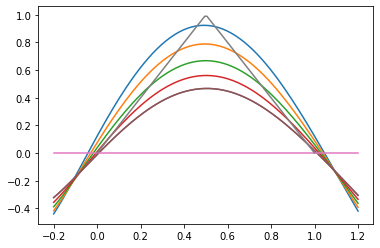

In [6]:
################################
################################
#%% Plot value function results 
################################
################################

#plt.plot(loss_list)



# value function
# Used for ploting results

V = model(t_interior_tnsr, X_interior_tnsr)


xs = np.linspace(-0.2,1.2, 140).reshape((140,1))
print(xs.shape)
for i in range(0,10,2):
    t = i * 0.01
    ts =  t * np.ones( shape = (140,1))

    fitted_Value = sess.run([V], feed_dict= {t_interior_tnsr:ts, X_interior_tnsr:xs})

    plt.plot(xs, fitted_Value[0],  label='DGM estimate')    




plt.plot(xs, fitted_Value[0],  label='DGM estimate')    
plt.plot(xs, np.zeros(xs.shape),  label='DGM estimate')    

steps =100
x= np.linspace(0,1,steps)
ic = np.piecewise(x, [x < 1/2, x>=1/2], [lambda x:2*x,lambda x:2-2*x])
plt.plot(x, ic)

[]


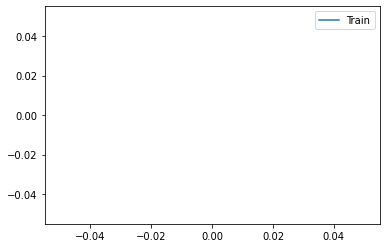

In [7]:
# n=2000*10 +200
# plt.plot(loss_list[n:n+1800], label="Train 10")
# plt.plot(loss_test_list[n:n+1800], label="Test10")
sample_set_n = 8
l = 100
n=2000*sample_set_n +l
plt.plot(loss_list[n:n+2000-l], label="Train")
#plt.plot(loss_test_list[n:n+2000-l], label="Test")

# n+=2000
# plt.plot(loss_list[n:n+2000])
# n+=2000
# plt.plot(loss_list[n:n+2000])
# n+=2000
# plt.plot(loss_list[n:n+2000])
# n+=2000
# plt.plot(loss_list[n:n+2000])
#plt.plot(loss_list[4000:n])

# print indices where the error more than doubles
loss_jumps = [i for i in range(0, len(loss_list)) if (loss_list[i-1] - loss_list[i]) > loss_list[i]]
plt.legend()
print(loss_jumps)

NameError: name 'loss_test_list' is not defined

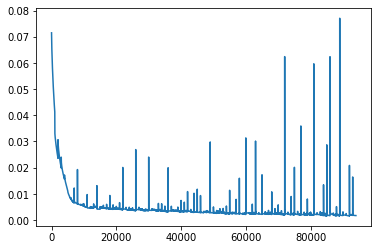

In [38]:
plt.plot(loss_list[6000:], label = "Training")
plt.plot(loss_test_list[6000:], label = "Validation")
plt.legend()

In [ ]:
l1_list = np.array(l1_list)

l1_list<1
plt.plot(l1_list[800:])

In [ ]:
plt.plot(l2_list[800:])

In [ ]:
l3_list = np.array(l3_list)
plt.plot(l3_list[800:])

In [ ]:
xs = np.linspace(0,1,100).reshape((-1,1))
ic_cond = tf.greater(xs, 1/2)

ys = tf.where(ic_cond, tf.add(2.0, tf.multiply(-2.0,X_interior_tnsr)), tf.multiply(2.0,X_interior_tnsr),)

ic_ys = sess.run([ys], feed_dict= {X_interior_tnsr:xs})

plt.plot(xs)
plt.plot(ic_ys[0])

In [ ]:
# https://en.wikipedia.org/wiki/Finite_difference_method#Example:_The_heat_equation

steps = 100
# h is the size of the step in the spatial dimention
h = 1/steps
# k is the size of the step in time dimension
k = 1/100000
x= np.linspace(0,1,steps)
ic = np.piecewise(x, [x < 1/2, x>=1/2], [lambda x:2*x,lambda x:2-2*x])


# We will save the solutions at each time step so we can plot the evelution of the temperature in the rod
u = [ic]

r = k/h**2 
assert r<=1/2, "This method is not Numerically stable if r>1/2"

# We will calculate 100 time frames
for i in range(100000):
    # calculate the next time frame u_n1 for each point x in the rod
    u_n1 = [0]
    # Note here u[i] represents the previous time frame
    for j in range(1, steps-1):
        u_n1.append((1-2*r)*u[i][j] + r*u[i][j-1] + r*u[i][j+1])
    
    u_n1.append(0)
        
    u.append(u_n1)

print(r)



In [ ]:
plt.plot(u[2], label = f"Time = {h*2}")
plt.plot(u[3], label = f"Time = {h*3}")
#plt.plot(u[4])
plt.plot(u[30], label = f"Time = {h*30}")
plt.plot(u[300], label = f"Time = {h*300}")
plt.plot(u[900], label = f"Time = {h*900}")
# plt.plot(u[3000], label = f"Time = {h*2}")
# plt.plot(u[6000], label = f"Time = {h*2}")
# plt.plot(u[9000], label = f"Time = {h*2}")
# plt.plot(u[30000], label = f"Time = {h*2}")
#plt.plot(u[90000], label = f"Time = {h*90000}")
plt.legend()


plt.show()

In [ ]:
FDM_time_steps = 200

xs = np.linspace(0,1,steps)
plt.plot(xs, u[FDM_time_steps], label = f"FDM Time = {FDM_time_steps*k}")

xs = np.linspace(-0.2,1.2, 140).reshape((140,1))
ts =  FDM_time_steps* k * np.ones( shape = (140,1))
fitted_Value = sess.run([V], feed_dict= {t_interior_tnsr:ts, X_interior_tnsr:xs})


plt.plot(xs, fitted_Value[0],  label=f'DGM Time = {FDM_time_steps*k}') 


plt.legend()
plt.show()

In [ ]:
#V = model(t_interior_tnsr, X_interior_tnsr)
table = []


FDM_delta_t = k
steps = [0, 10, 100, 1000, 10000, 5*10000, 9*10000]

xs = np.linspace(0,1,100).reshape((-1,1))
for step in steps[-1:]:
    t = k * step
    ts =  t * np.ones( shape = xs.shape)

    fitted_Value = sess.run([V], feed_dict= {t_interior_tnsr:ts, X_interior_tnsr:xs})
    
    
    # Take the RMS of the differences at the grid points in in the 
    rms =  np.linalg.norm(u[step] - fitted_Value[0].T)/xs.size
    
    #plt.plot(xs, u[step], label = f"FDM Time = {FDM_time_steps*k}")
    plt.plot(xs, fitted_Value[0],  label=f'DGM Time = {FDM_time_steps*k}') 
    
    
    table.append([t, rms])
    
columns = ["Time", "Average RMS Between FDM and DGM"]
data = np.array(table)
df = pd.DataFrame(data=data, columns=columns)
display(df)
    